In [1]:
import numpy as np
import torch
import torch.nn as nn
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # 4-layer NN, 1-dim input layer, 2 hidden layers with 12-dim and 1 output layer with 1-dim
        self.net = nn.Sequential(
            nn.Linear(1,19),
            nn.Tanh(),
            nn.Linear(19,19),
            nn.Tanh(),
            nn.Linear(19,19),
            nn.Tanh(),
            nn.Linear(19,1)
        )
    def forward(self,x):
        return self.net(x)

In [2]:
def g(x):
    
    result = 1- (1/(1.+torch.exp(1+x)))
    return result

def f(t,x,y,z):
    return (y - 1.5)*z


def true_u(t,x):
    return 1-(1./(1+torch.exp(t+x)))

t = torch.linspace(0,1,101,dtype = torch.float32)
dt = t[1]-t[0] 
eta = 0.005
# total updates for gradient descent
N_epoch = 1000
# batch_size
N_MC = 256
#BM for each iteration
BM_mat = torch.sqrt(dt) * np.random.normal(size = (N_MC,len(t)-1))
BM_mat = BM_mat.to(t.dtype)

# DOES NOT WORK FOR SIN EXAMPLE
def g(x):
    return torch.cos(x)

def f(t,x,y,z):
    T = 1
    sigma = 1
    mu = 0
    coef_1 = torch.cos(x)*(torch.exp((T-t)/2)+1/2)+mu*torch.sin(x)
    coef_2 = torch.exp((T-t)/2)
    coef_3 = 0.5 *(torch.sin(x)*torch.cos(x)*torch.exp(T-t))**2
    coef_4 = 0.5 *y**2*z**2
    result = coef_1*coef_2-coef_3+coef_4
    return result
def true_u(t,x):
    return torch.exp((1-t)/2)*g(x)

t = torch.linspace(0,1,241,dtype = torch.float32)
dt = t[1]-t[0] 
eta = 0.001
# total updates for gradient descent
N_epoch = 1000
# batch_size
N_MC = 256
#BM for each iteration
BM_mat = torch.sqrt(dt) * np.random.normal(size = (N_MC,len(t)-1))
BM_mat = BM_mat.to(t.dtype)

In [3]:
# Create NN
# Create a list of NN
NN_list = list()
param_list = list()
for ind in range(len(t)):
    NN = Model()
    NN_list.append(NN)
    param_list = param_list + list(NN.parameters())
opt = torch.optim.Adam(param_list,lr = eta)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=500, gamma=0.1)

In [4]:
loss_history = list()


# Iteration count
for k in range(N_epoch):
    # Do M times of simulations to approximate the loss function by Monte Carlo, use a batch of size M in practice
    # so we don't need to run the NN for a lot of times repeatedly
    
    # X0
    X_hat =  torch.distributions.uniform.Uniform(-4, 4).sample((N_MC,1))
    #X_hat = torch.ones((N_MC,1))
    X_hat = torch.squeeze(X_hat)
    # U0
    U_hat = torch.squeeze(NN_list[0](torch.unsqueeze(X_hat,1)))

    # At the i-th time point
    for i in range(len(t) - 1):
        # Zi
        Z_hat =  torch.squeeze(NN_list[i+1](torch.unsqueeze(X_hat,1)))

        # U approx based on derivative apperox Z
        
        next_U_hat = U_hat - f(i*dt,X_hat,U_hat,Z_hat) *dt +Z_hat * BM_mat[:,i]
        
        # Simulate X_hat
        next_X_hat = X_hat + 0.0 * dt +1 * BM_mat[:,i]

        # Update X_hat,U_hat,Z_hat
        X_hat = next_X_hat
        U_hat = next_U_hat

        # Note: we CANNOT organize X_hat as a tensor with dimension max_step * M * N and record all simulation results
        # of X in the same tensor (although in disjoint regions). This is because Pytorch takes this as "in-place"
        # The definition of "in-place" operations: an operation that changes directly the content of a given Tensor 
        # without making a copy.
        # operation and this results in failures in tracking the gradient. Some other examples of "in-place" operations
        # are like "+=", "*=", however, "X = X + 1" is not considered "in-place".
        # Be careful with this point and always use "X_hat", "next_X_hat" scheme when training the NN.
            
    # Compute loss
    loss = torch.sum((U_hat - g(X_hat)) ** 2) / (N_MC)
    
    # Print loss every 100 iterrations
    if k % 10 == 0:
        print('Iter: ' + str(k) + ', Loss: ' + str(loss.detach()))
        
    # Record loss and Y_init for plotting
    # Note: we shall clone after detaching to make deep copies
    loss_history.append(loss.detach().clone())
    
    # Back propagation
    opt.zero_grad()
    loss.backward()
    
    # Update NN parameters and Y_init
    opt.step()

Iter: 0, Loss: tensor(0.3327)
Iter: 10, Loss: tensor(0.0284)
Iter: 20, Loss: tensor(0.0104)
Iter: 30, Loss: tensor(0.0047)
Iter: 40, Loss: tensor(0.0022)
Iter: 50, Loss: tensor(0.0016)
Iter: 60, Loss: tensor(0.0012)
Iter: 70, Loss: tensor(0.0007)
Iter: 80, Loss: tensor(0.0008)
Iter: 90, Loss: tensor(0.0005)
Iter: 100, Loss: tensor(0.0004)
Iter: 110, Loss: tensor(0.0003)
Iter: 120, Loss: tensor(0.0004)
Iter: 130, Loss: tensor(0.0004)
Iter: 140, Loss: tensor(0.0003)
Iter: 150, Loss: tensor(0.0002)
Iter: 160, Loss: tensor(0.0003)
Iter: 170, Loss: tensor(0.0002)
Iter: 180, Loss: tensor(0.0002)
Iter: 190, Loss: tensor(0.0002)
Iter: 200, Loss: tensor(0.0001)
Iter: 210, Loss: tensor(0.0002)
Iter: 220, Loss: tensor(0.0001)
Iter: 230, Loss: tensor(0.0001)
Iter: 240, Loss: tensor(0.0001)
Iter: 250, Loss: tensor(9.9147e-05)
Iter: 260, Loss: tensor(8.5715e-05)
Iter: 270, Loss: tensor(0.0001)
Iter: 280, Loss: tensor(8.4439e-05)
Iter: 290, Loss: tensor(8.1738e-05)
Iter: 300, Loss: tensor(7.5536e-05)

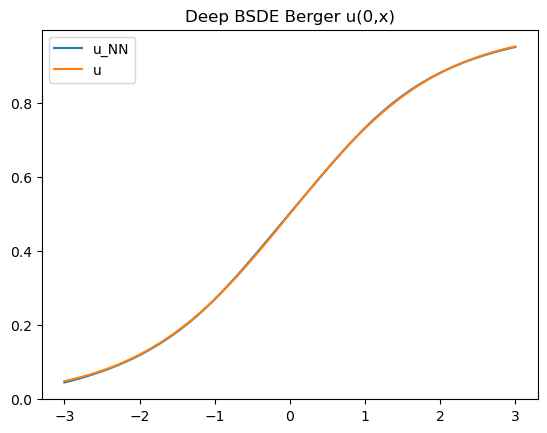

In [17]:
x = torch.linspace(-3,3,100)
u_hat = torch.squeeze(NN_list[0](torch.unsqueeze(x,1)))
u = true_u(t[0],x)
import matplotlib.pyplot as plt
plt.plot(x,u_hat.detach().numpy(),label = "u_NN")
plt.plot(x,u,label = "u")
plt.title("Deep BSDE Berger u(0,x)")
plt.legend()
plt.plot()
plt.show()

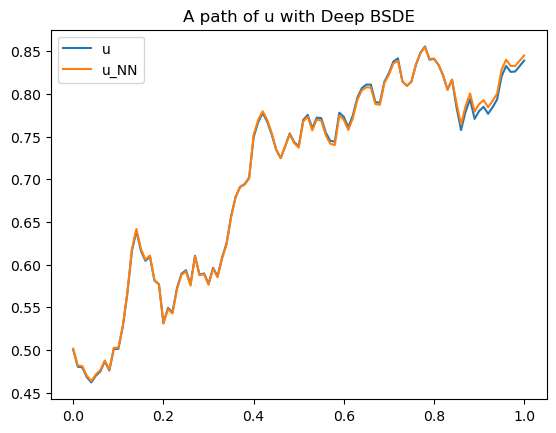

In [19]:
import matplotlib.pyplot as pltb
plt.plot(t,u,label = "u")
plt.plot(t,pred_u.detach().numpy(),label = "u_NN")
plt.legend()
plt.title("A path of u with Deep BSDE")
plt.show()

In [18]:
N =1
BM_1 = torch.sqrt(dt) * np.random.normal(size = (N,len(t)-1))
X_1 = torch.zeros((N,len(t))) 
X_1[:,0] = 0
pred_u = torch.zeros(len(t))
u = torch.zeros(len(t))

u[0]= true_u(t[0],X_1[:,0])
pred_u[0] = torch.squeeze(NN_list[0](X_1[:,0]))
for i in range(1,len(t)):
    X_1[:,i] = X_1[:,i-1] + BM_1[:,i-1] 
    # true u(t_i,x_i)
    u[i] = true_u(t[i],X_1[:,i])

    
    Z_hat =  torch.squeeze(NN_list[i](X_1[:,i-1]))
    # U approx based on derivative apperox Z

    next_U_hat = pred_u[i-1] - f(i*dt,X_1[:,i-1],pred_u[i-1],Z_hat) *dt +Z_hat * BM_1[:,i-1]

    pred_u[i] = next_U_hat